# Warsaw Air Quality Estimator: Project Overview
*This is the world we live in and this is the air we breathe*  
  
so it matters! (at least for me :) )  
During the last couple of years we observe alarming level of air polution in Poland. Since I live in Warsaw and this is capital of Poland, I will try to investigate and understand air quality I breathe using historical weather data. Based on that I will build air quality estimator which can predict air polution level based on weather forecast/real time data.

The aim of this project is to utilize machine learning models to predict air quality in Warsaw based on historical weather data. This project consist following steps:
* Build unique dataset based on NASA POWER LARC and Air Quality Historical Data Platform and utilized Pandas for data structuring
* EDA: Analysis and visualisation of data using matplotlib and seaborn. Investigate air polution patterns and impact of the covid 19 lockdown on air quality in Warsaw
* Deployed linear regression, ridge, random forest and boosted methods to identify best model. 
* Optimized best performing model using GridsearchCV to reach the best score. 
* Validate model performance on real time data using IMGW API and web scrapping (BeautifulSoup)

## Data preparation and cleaning

The aim of this section is to:
- import data
- select correct data types
- merge both files

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Weather data
File: 'nasa_warsaw_weather_clean.csv'  
Source: https://power.larc.nasa.gov/data-access-viewer/![image.png](attachment:image.png)  
  
  Data explenation:
  
- T2M_MAX - Maximum Temperature at 2 Meters (C) 
- T2M_MIN - Minimum Temperature at 2 Meters (C) 
- T2M - Temperature at 2 Meters (C) 
- WS10M_RANGE - Wind Speed Range at 10 Meters (m/s) 
- WS10M - Wind Speed at 10 Meters (m/s) 
- T2M_RANGE - Temperature Range at 2 Meters (C) 
- WS50M - Wind Speed at 50 Meters (m/s) 
- PRECTOT - Precipitation (mm day-1) 
- WS50M_RANGE - Wind Speed Range at 50 Meters (m/s) 
- QV2M - Specific Humidity at 2 Meters (g/kg) 
- PS - Surface Pressure (kPa) 
- RH2M - Relative Humidity at 2 Meters (%)  
  
Date range: 01/01/2015 - 05/31/2021


In [3]:
df_nasa = pd.read_csv('nasa_warsaw_weather_clean.csv')

In [4]:
df_nasa.head()

,LAT,LON,YEAR,MO,DY,T2M_MAX,T2M_MIN,T2M,PRECTOT,QV2M,RH2M,PS,WS50M_RANGE,WS10M_RANGE,WS50M,WS10M,T2M_RANGE
0,52.22961,21.01811,2015,1,1,1.19,-0.74,0.11,0.83,3.64,95.86,101.22,2.05,1.79,7.64,5.64,1.94
1,52.22961,21.01811,2015,1,2,2.67,-0.64,1.34,1.40,3.89,92.70,100.07,8.08,5.94,12.18,9.06,3.31
2,52.22961,21.01811,2015,1,3,2.55,0.23,1.53,2.31,3.87,90.51,99.53,5.95,4.61,15.00,11.33,2.31
3,52.22961,21.01811,2015,1,4,1.95,-0.00,0.54,0.57,3.40,85.08,99.30,2.94,2.15,12.48,9.39,1.95
4,52.22961,21.01811,2015,1,5,1.30,-4.00,-1.53,0.23,2.91,85.77,100.27,3.52,2.58,9.90,7.40,5.29


Year, month and day are on seprate columns. I will merge this 3 columns in new 'date' and chenge type to datetime.

In [5]:
df_nasa['date'] = df_nasa['YEAR'].astype(str) + '.' + df_nasa['MO'].astype(str) + '.' + df_nasa['DY'].astype(str)

In [6]:
df_nasa['date'] = pd.to_datetime(df_nasa['date'], format='%Y.%m.%d')

### Air polution data
File: 'air_qual_marszalkowska.csv'  
Source: https://aqicn.org/data-platform/register/![image.png](attachment:image.png)  
- PM2,5
- PM 10
- O3
- NO2
- SO2
- CO


In [7]:
df_air = pd.read_csv('air_qual_marszalkowska.csv')

In [8]:
df_air = df_air.replace(' ','0')

In [9]:
df_air[[' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']] = df_air[[' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']].astype(float)

In [10]:
df_air['date'] = pd.to_datetime(df_air['date'], format='%Y/%m/%d')

In [11]:
df = df_nasa.merge(df_air)

In [12]:
df.shape

(2257, 24)

In [13]:
df.columns

Index(['LAT', 'LON', 'YEAR', 'MO', 'DY', 'T2M_MAX', 'T2M_MIN', 'T2M',
       'PRECTOT', 'QV2M', 'RH2M', 'PS', 'WS50M_RANGE', 'WS10M_RANGE', 'WS50M',
       'WS10M', 'T2M_RANGE', 'date', ' pm25', ' pm10', ' o3', ' no2', ' so2',
       ' co'],
      dtype='object')

For further analysis I will remove unnecessary columns (latitude, longitude, year, month, day, temperature and wind range).

In [14]:
df = df[['date', 'T2M_MAX', 'T2M_MIN', 'T2M',
       'PRECTOT', 'QV2M', 'RH2M', 'PS', 'WS50M',
       'WS10M', ' pm25', ' pm10', ' o3', ' no2', ' so2',
       ' co']]

In [15]:
df.columns = map(str.lower, df.columns)
df.columns = map(str.strip, df.columns)

# EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2257 entries, 0 to 2256
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2257 non-null   datetime64[ns]
 1   t2m_max  2257 non-null   float64       
 2   t2m_min  2257 non-null   float64       
 3   t2m      2257 non-null   float64       
 4   prectot  2257 non-null   float64       
 5   qv2m     2257 non-null   float64       
 6   rh2m     2257 non-null   float64       
 7   ps       2257 non-null   float64       
 8   ws50m    2257 non-null   float64       
 9   ws10m    2257 non-null   float64       
 10  pm25     2257 non-null   float64       
 11  pm10     2257 non-null   float64       
 12  o3       2257 non-null   float64       
 13  no2      2257 non-null   float64       
 14  so2      2257 non-null   float64       
 15  co       2257 non-null   float64       
dtypes: datetime64[ns](1), float64(15)
memory usage: 299.8 KB


In [17]:
df.describe()

,t2m_max,t2m_min,t2m,prectot,qv2m,rh2m,ps,ws50m,ws10m,pm25,pm10,o3,no2,so2,co
count,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000
mean,13.382809,4.707350,8.989650,1.750935,6.012153,77.520678,100.173031,6.361905,4.410837,74.922907,33.001772,3.422242,20.544085,0.351351,6.160833
std,9.939179,7.813885,8.922169,3.369466,2.844652,14.132160,0.837841,2.260476,1.737893,35.115088,16.830717,9.797973,12.019448,1.294488,3.310111
min,-16.130000,-23.790000,-19.400000,0.000000,0.660000,35.090000,96.380000,1.240000,0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.690000,-1.140000,1.720000,0.050000,3.760000,66.180000,99.670000,4.780000,3.130000,53.000000,23.000000,0.000000,14.000000,0.000000,4.000000
50%,13.280000,4.390000,8.480000,0.390000,5.400000,79.020000,100.180000,6.160000,4.170000,67.000000,31.000000,0.000000,19.000000,0.000000,6.000000
75%,21.970000,11.300000,16.880000,1.860000,7.990000,90.530000,100.720000,7.690000,5.440000,93.000000,42.000000,0.000000,25.000000,0.000000,8.000000
max,36.180000,21.300000,28.930000,37.290000,14.980000,100.000000,102.850000,16.200000,12.140000,283.000000,151.000000,82.000000,173.000000,18.000000,48.000000


In [18]:
df.set_index('date', inplace=True)

In [19]:
df.head()

,t2m_max,t2m_min,t2m,prectot,qv2m,rh2m,ps,ws50m,ws10m,pm25,pm10,o3,no2,so2,co
date,,,,,,,,,,,,,,,
2015-01-01,1.19,-0.74,0.11,0.83,3.64,95.86,101.22,7.64,5.64,0.0,18.0,16.0,21.0,16.0,5.0
2015-01-02,2.67,-0.64,1.34,1.40,3.89,92.70,100.07,12.18,9.06,72.0,0.0,19.0,11.0,6.0,5.0
2015-01-03,2.55,0.23,1.53,2.31,3.87,90.51,99.53,15.00,11.33,0.0,0.0,21.0,6.0,4.0,4.0
2015-01-04,1.95,-0.00,0.54,0.57,3.40,85.08,99.30,12.48,9.39,0.0,10.0,27.0,4.0,5.0,4.0
2015-01-05,1.30,-4.00,-1.53,0.23,2.91,85.77,100.27,9.90,7.40,50.0,0.0,18.0,6.0,2.0,5.0


### Temperature

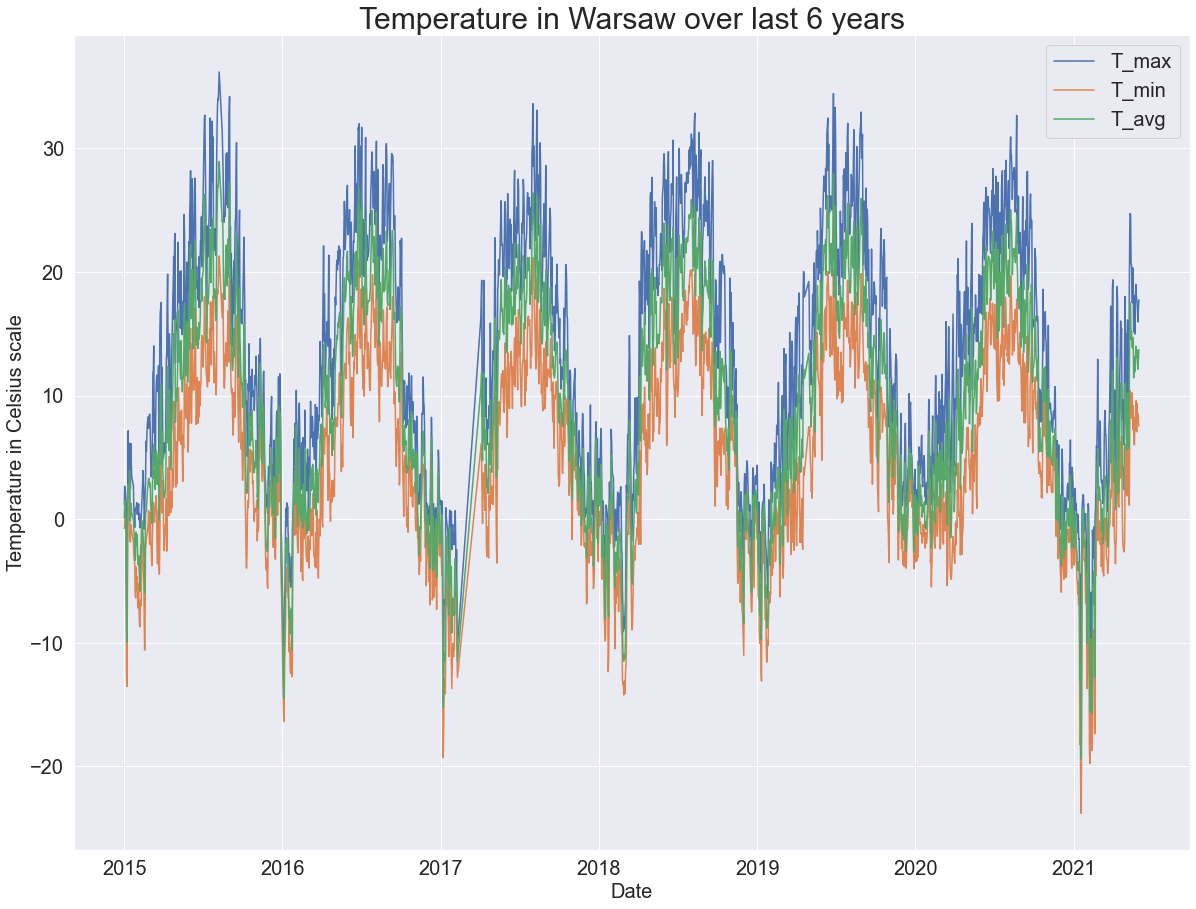

In [211]:
# Temperature plots

sns.set_style("darkgrid")
plt.figure(figsize=(20,15))
sns.lineplot(data = df, x = df.index, y='t2m_max', label='T_max')
sns.lineplot(data = df, x = df.index, y='t2m_min', label='T_min')
sns.lineplot(data = df, x = df.index, y='t2m', label='T_avg')



plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Temperature in Celsius scale', fontsize=20)
plt.yticks(fontsize=20)
plt.title('Temperature in Warsaw over last 6 years',fontsize=30)
plt.legend(fontsize=20)
# plt.savefig(fname='Temperature.jpg')
plt.show()



#### Comment/Observation:
- missing data: February 2017
- very cold winter in 2021


### PM2.5 level
To present PM2.5 level in each day over last 6 years I will create heatmaps. To do so, I will use datetime atributes to obtain day, month and year for each observation and create list of years.

In [20]:
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

In [21]:
years = df.year.unique()

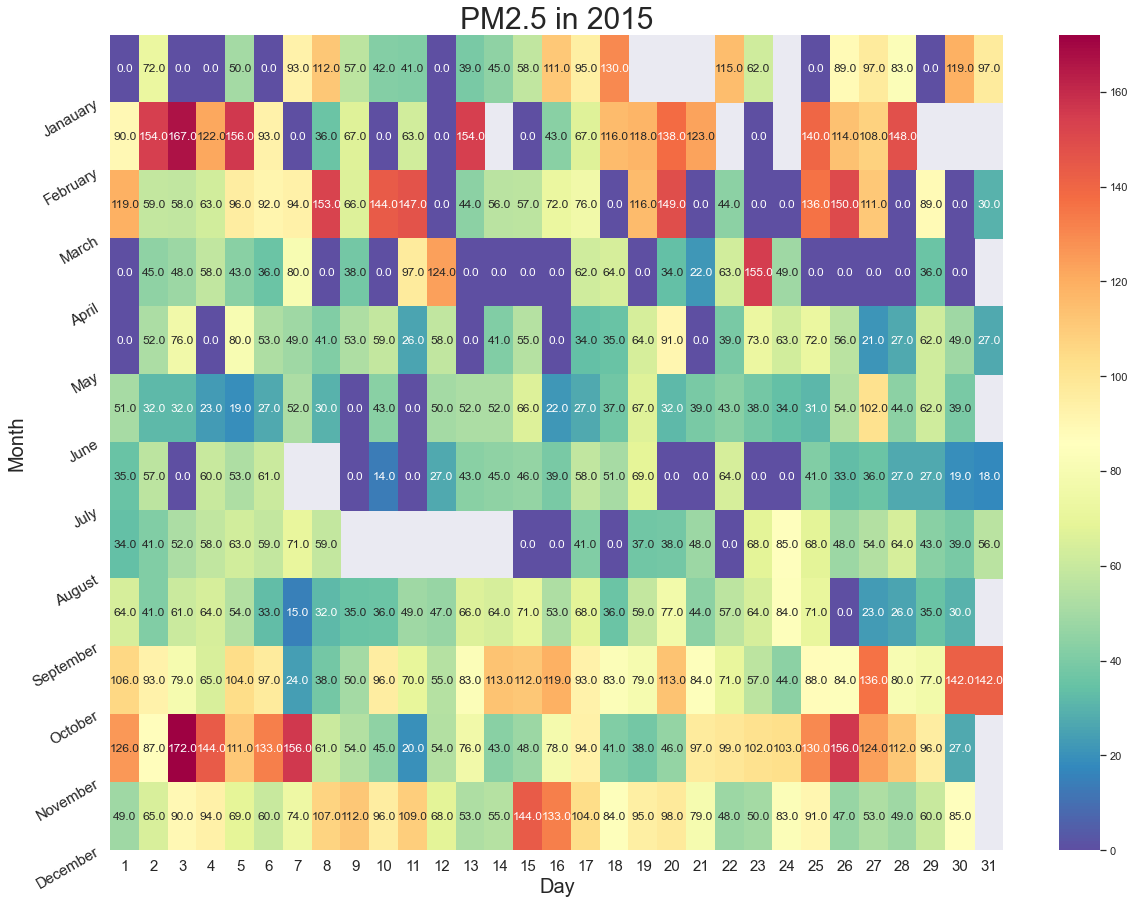

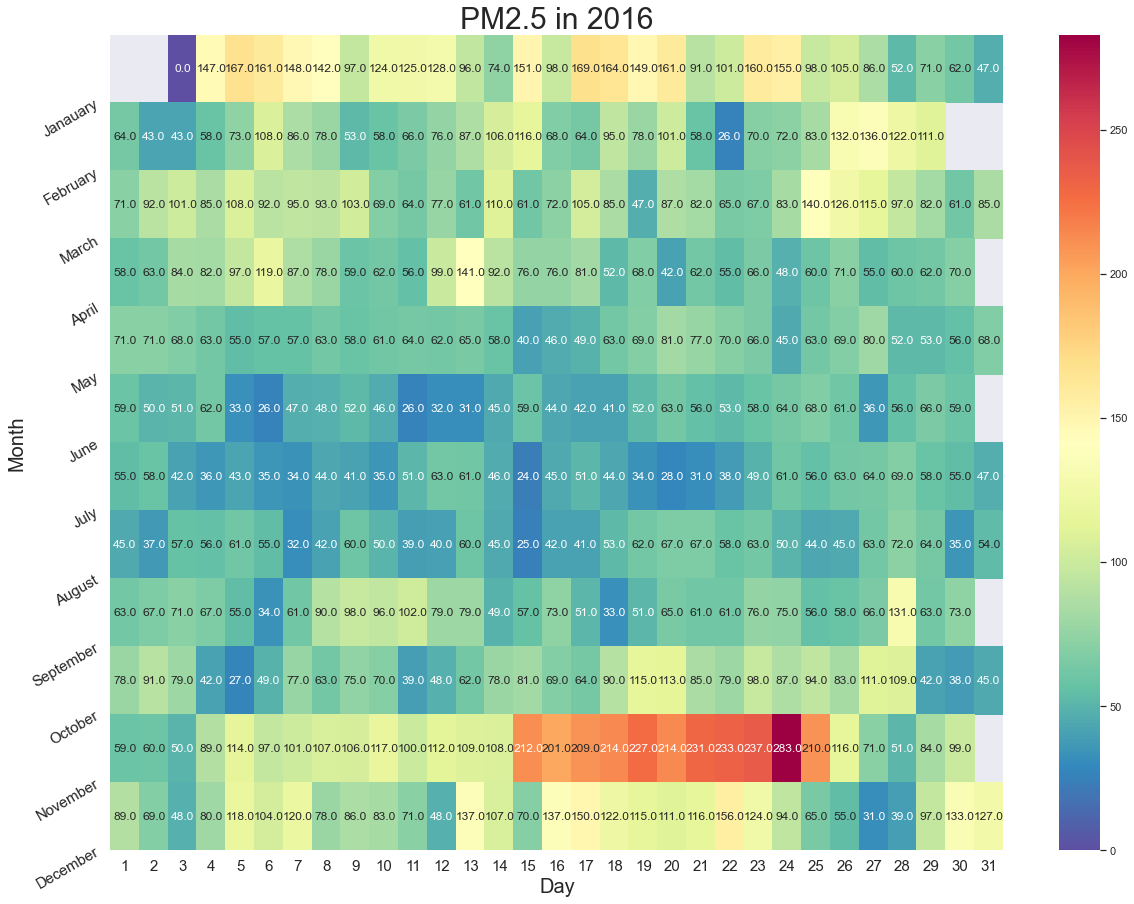

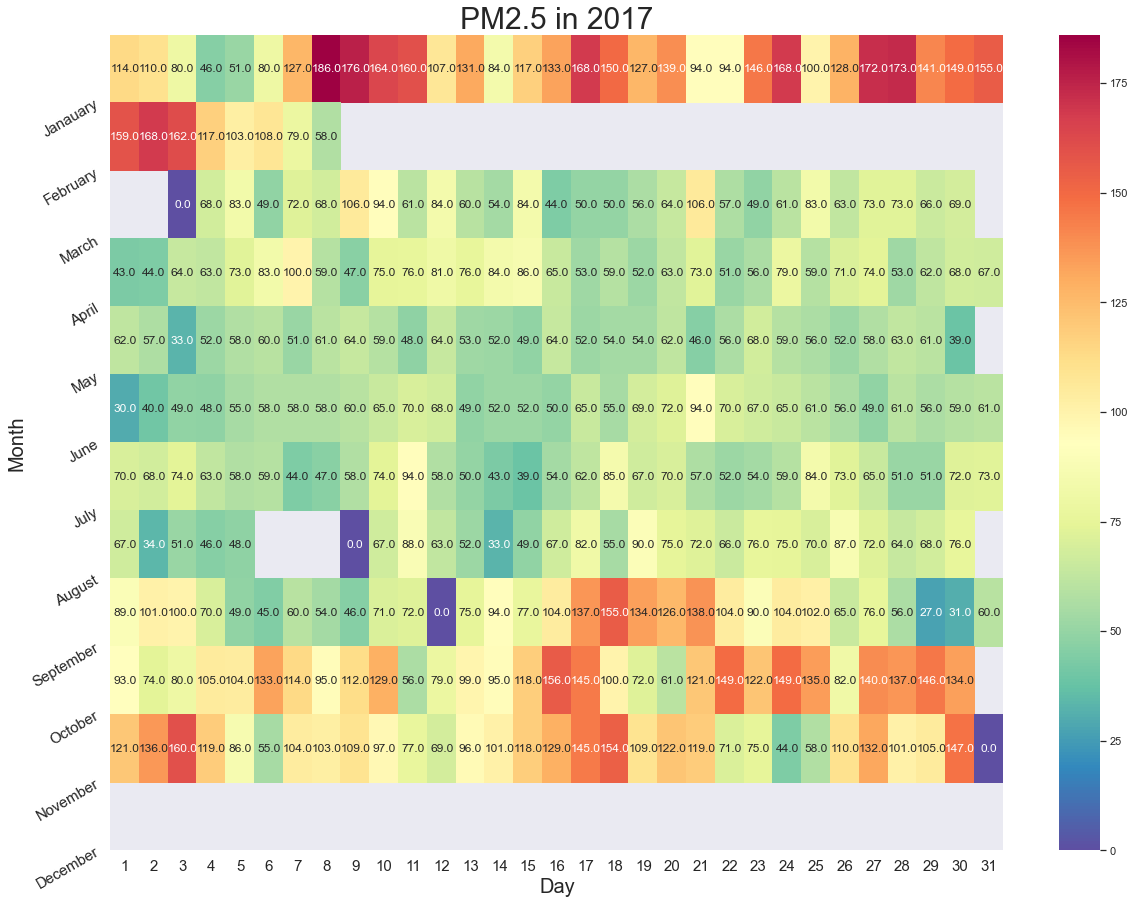

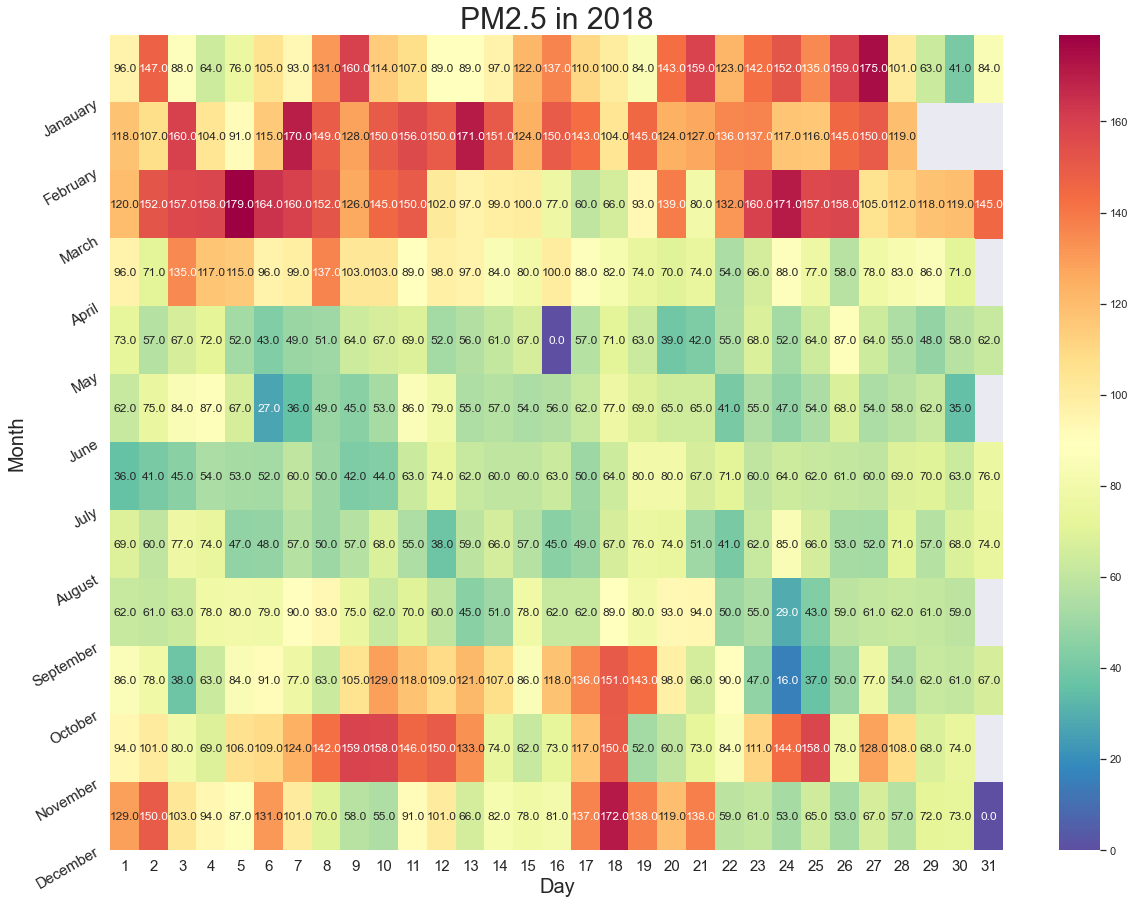

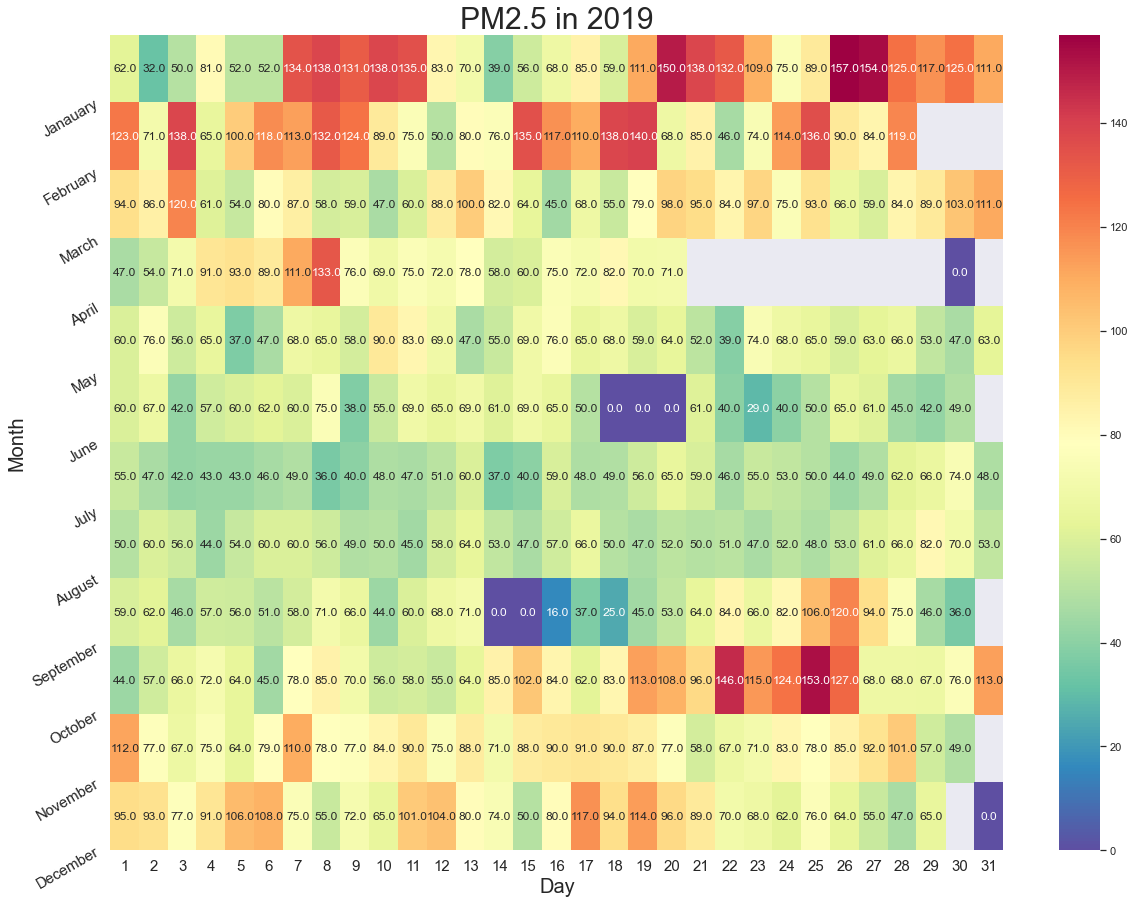

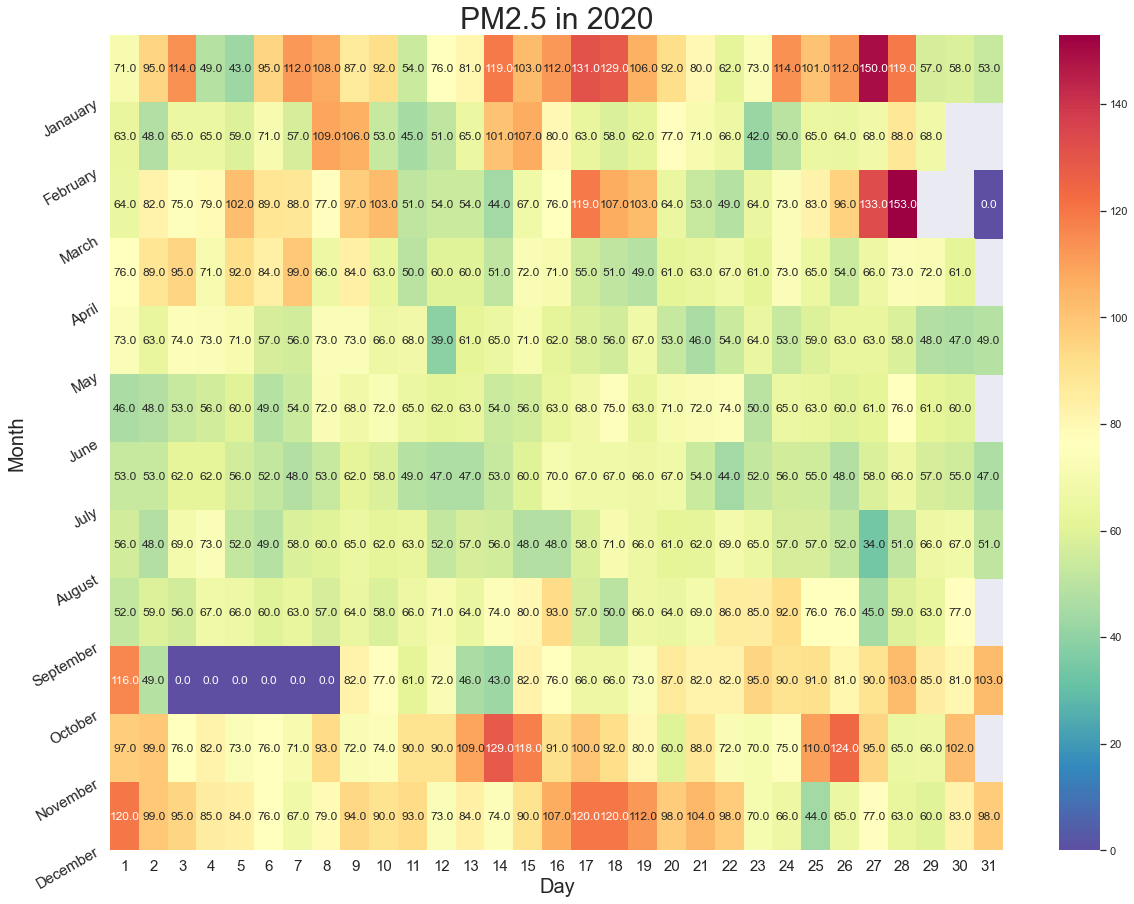

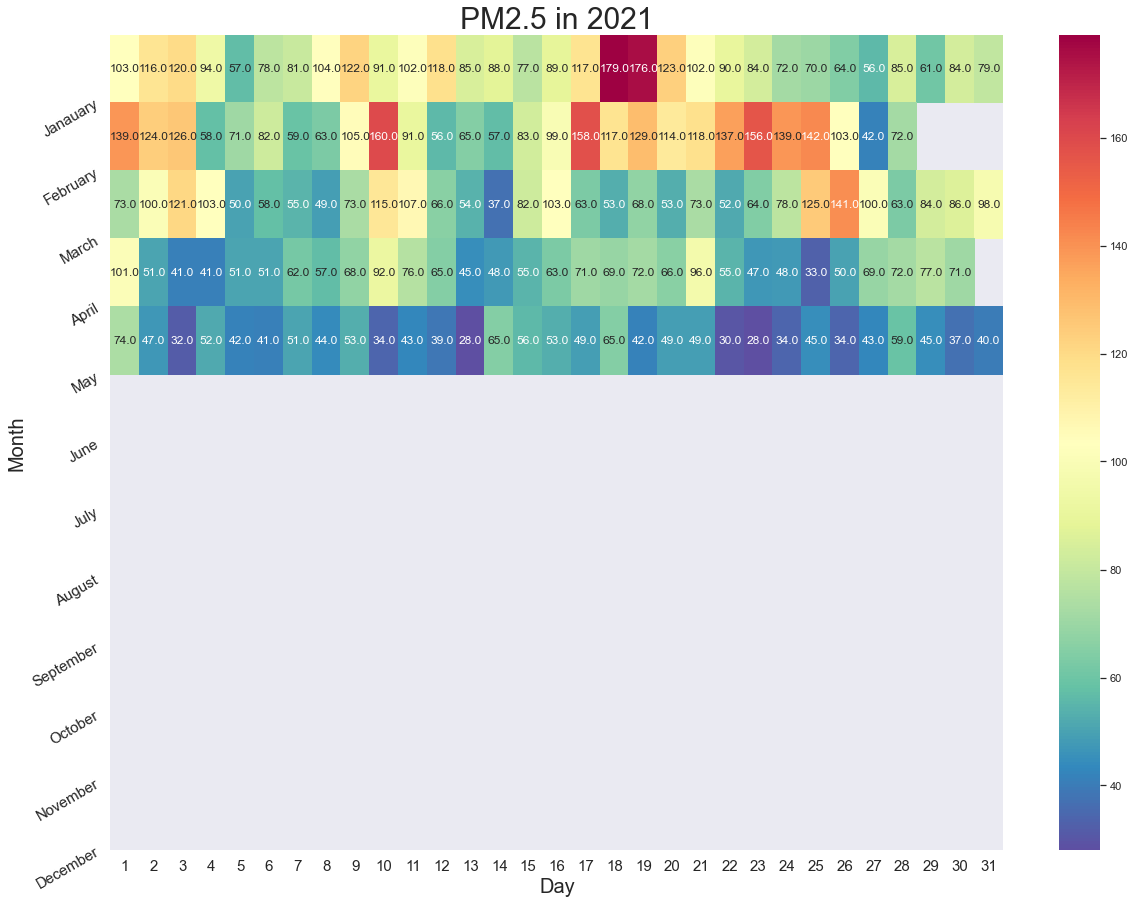

In [150]:
for year in years:
    df_temp = df[df['year'] == year]
    
    plt.figure(figsize=(20,15))
    example_pivot = df_temp.pivot('month', 'day', 'pm25')
    hm = sns.heatmap(example_pivot, annot=True, fmt='.1f', cmap="Spectral_r")

    plt.xlabel('Day', fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylabel('Month', fontsize=20)
    plt.yticks(fontsize=15, rotation=30, ticks=[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], labels=['Janauary', 'February', 'March', 'April', 'May', 'June', 'July',
           'August', 'September', 'October', 'November', 'December'])
    plt.title(f"PM2.5 in {year}",fontsize=30)
#     plt.savefig(fname=f'PM25_{year}.jpg')
    plt.show()
    

#### Comment/Observation:
- PM2.5 level higher during winter time
- Missing days can be easily observed (February 2017, April 2019)
- Quality of first months of 2015 is questionable (a lot of zeros, zeros close between high pm2.5 values)


It is known (and hetmap above confirms it), that air quality in Warsaw is worse during winter. Let's see how does it look on the real plot in terms of temperature and wind.

<Figure size 1440x1080 with 0 Axes>

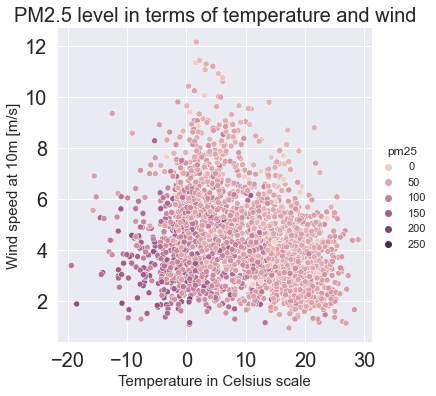

In [164]:
plt.figure(figsize=(20,15))
sns.relplot(x = 't2m', y='ws10m', hue='pm25', data=df)

plt.xlabel('Temperature in Celsius scale', fontsize=15)
plt.xticks(fontsize=20)
plt.ylabel('Wind speed at 10m [m/s]', fontsize=15)
plt.yticks(fontsize=20)
plt.title('PM2.5 level in terms of temperature and wind',fontsize=20)
# plt.savefig(fname='PM25_temp_wind.jpg', pad_inches=0.6)


plt.show()

We see that the worst air quality is observed during cold day without wind.

In [22]:
#Removing first 5 months of 2015 due to bad quality of data

df = df['2015-06':]

### Covid 19 impact on air quality in Warsaw

During the first weeks of pandemia the world stopped for a second. Schools, factories and offices were closed to prevet spread of the virus.  
Let's see if it changes PM2.5 level in the Warsaw city ceter by comparing it to previous years.

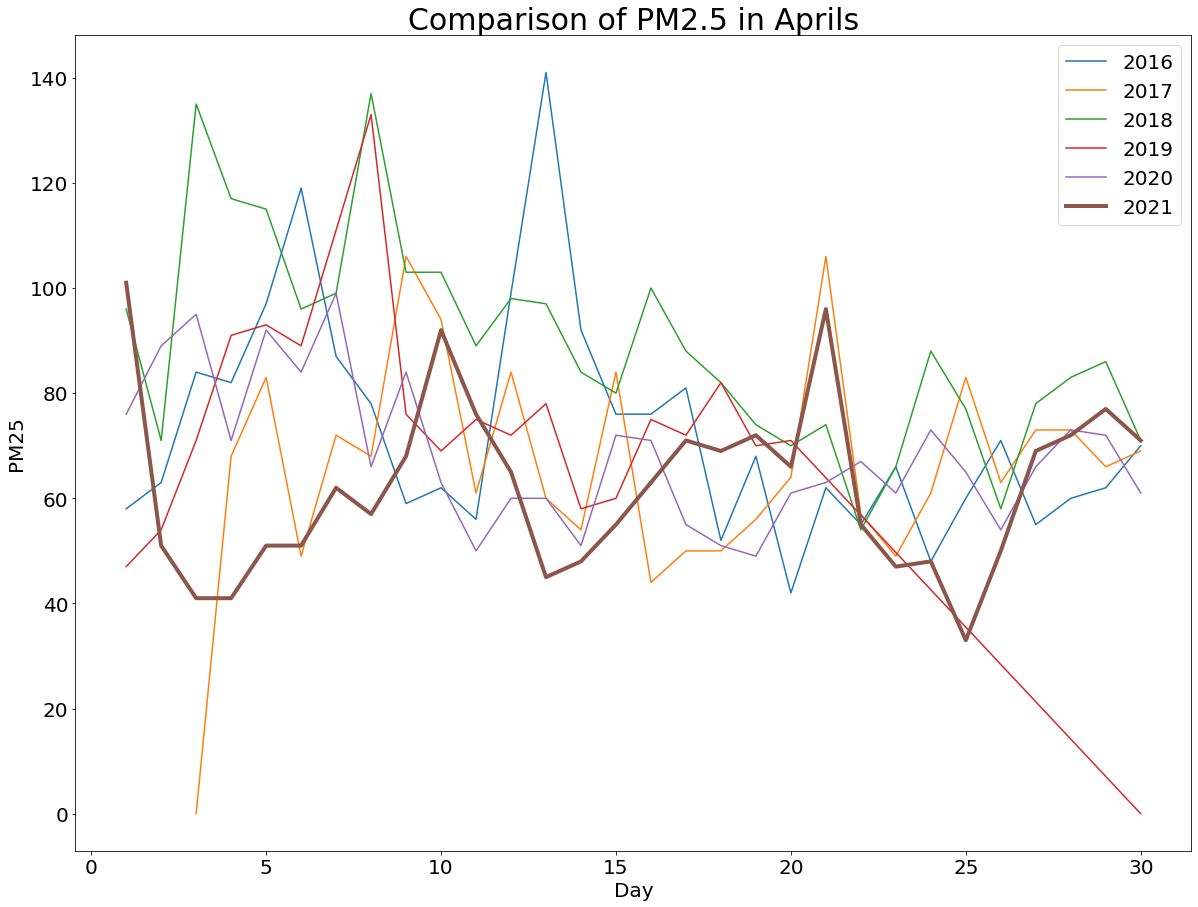

In [24]:
df_temp = df[df['month'] == 4]

plt.figure(figsize=(20,15))

# sns.lineplot(data = df_temp[df_temp['year'] == 2015], x = 'day', y='pm25', label='2015')
sns.lineplot(data = df_temp[df_temp['year'] == 2016], x = 'day', y='pm25', label='2016')
sns.lineplot(data = df_temp[df_temp['year'] == 2017], x = 'day', y='pm25', label='2017')
sns.lineplot(data = df_temp[df_temp['year'] == 2018], x = 'day', y='pm25', label='2018')
sns.lineplot(data = df_temp[df_temp['year'] == 2019], x = 'day', y='pm25', label='2019')
sns.lineplot(data = df_temp[df_temp['year'] == 2020], x = 'day', y='pm25', label='2020')
sns.lineplot(data = df_temp[df_temp['year'] == 2021], x = 'day', y='pm25', label='2021', linewidth=4)

plt.xlabel('Day', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('PM25', fontsize=20)
plt.yticks(fontsize=20)
plt.title('Comparison of PM2.5 in Aprils',fontsize=30)
plt.legend(fontsize=20)
plt.savefig(fname='PM25_covid.jpg')

plt.show()

#### Comment/Observation:

- Note: 2021 curve is highlighted
- PM2.5 lvl is significantly lower during firts week and in general rather lower than in previous years
- missing days can be observed (2019, 2017)
- 2015 was omitted due to bad quality of data
  
To confirm our observation let's check average temperature and average PM2.5 level in April for each year.

In [25]:
df_temp.groupby('year')[['t2m', 'pm25']].mean()

,t2m,pm25
year,,
2016,8.856000,72.700000
2017,6.235714,65.964286
2018,12.127333,88.966667
2019,7.683333,73.666667
2020,8.069333,68.466667
2021,6.260000,62.100000


The average temperature in 2021 was one of the lowest, but due to coronavirus lockdown PM2.5 level was the lowest.

### Correlations
Quality of air is obtain by measuring several factors such as PM2.5, PM10, NO2.  
For this analysis I will focus on PM2.5, thus I will remove columns with other air polutions.

In [26]:
df = df[['t2m_max', 't2m_min', 't2m', 'prectot', 'qv2m', 'rh2m', 'ps', 'ws50m',
       'ws10m', 'pm25']]

In [27]:
corr = df.corr()

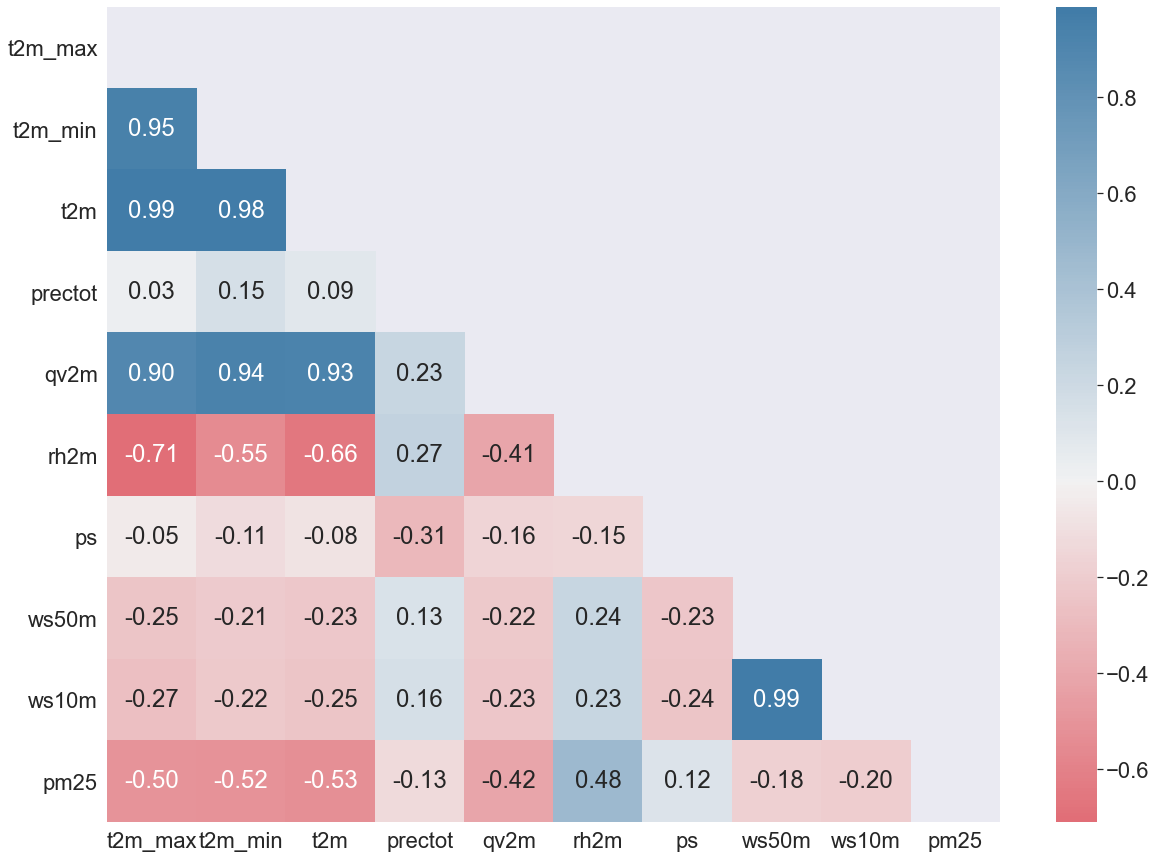

In [170]:
plt.figure(figsize=(20,15))
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))   #zostawia tylko dolny trojkat
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, mask=mask, center=0, cmap=cmap, annot=True, fmt=".2f")
sns.set(font_scale=2)
# plt.savefig(fname='Correlation_heatmap.jpg')
plt.show()

#### Comment/Observation:

- Winds at 10m and 50m are highly correlated. For further analysis I will use only wind speed at 50m.
- Max, min and avg temperatures plus Specific Humidity at 2 Meters are highly correlated (above 0.9). I will keep only average temperature


# Model preparation

1. Features standarized using StandardScaler  
2. Models comparison with default hyperparameters using cross validation (with negative mean squared error as scoring):
    - KNeighborsRegressor,
    - LinearRegression,
    - Ridge, 
    - DecisionTreeRegressor, 
    - RandomForestRegressor, 
    - GradientBoostingRegressor
    - XGBRegressor

3. Optimization of best performing model using GridSearchCV.
4. Add additional binary feature 'weekday' and verify wather it improves model performance.
5. Plot feature importances.


In [28]:
df_1 = df.copy()

In [29]:
X = df_1[['t2m', 'prectot', 'rh2m', 'ps', 'ws50m']]

y = df_1['pm25']

In [30]:
# models

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost

# preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [31]:
models = {'KNN': KNeighborsRegressor(),
         'LinearRegression': LinearRegression(),
         'Ridge': Ridge(),
         'DecisionTreeRegressor' : DecisionTreeRegressor(),
         'RandomForestRegressor' : RandomForestRegressor(),
         'GradientBoostingRegressor' : GradientBoostingRegressor(),
         'XGBRegressor': xgboost.XGBRegressor()}

In [32]:
list(models.keys())

['KNN',
 'LinearRegression',
 'Ridge',
 'DecisionTreeRegressor',
 'RandomForestRegressor',
 'GradientBoostingRegressor',
 'XGBRegressor']

In [33]:
models_rst = []

In [34]:
for model_name, model in models.items():
    steps = [('pre', StandardScaler()), ('model', model)]
    pipe = Pipeline(steps)
    cv_score = cross_val_score(pipe, X, y, cv=10, scoring='neg_mean_squared_error')
    print(f'{model_name} cv mean is {-cv_score.mean()}')
    models_rst.append(-cv_score.mean())

KNN cv mean is 763.5267709022623
LinearRegression cv mean is 674.5147062008921
Ridge cv mean is 674.4961617910014
DecisionTreeRegressor cv mean is 1246.1445117589196
RandomForestRegressor cv mean is 659.1677893465528
GradientBoostingRegressor cv mean is 621.4993999829553
XGBRegressor cv mean is 747.978207180813


In [35]:
models_rst

[763.5267709022623,
 674.5147062008921,
 674.4961617910014,
 1246.1445117589196,
 659.1677893465528,
 621.4993999829553,
 747.978207180813]

In [36]:
df_models = pd.DataFrame({'Model':list(models.keys()), 'MSE':models_rst})

#### The best model: GradientBoostingRegressor

Now I will try to improve GradientBoostingRegressor performance using GridSearchCV.  
GradientBoostingRegressoris tree-based model so standarization of features is not needed.

In [37]:
param_grid = {"min_samples_split": [1,2,5],
             "max_depth": [2,3,5],
              "min_samples_leaf": [1,2,5],
              "n_estimators":[50, 70, 100],
              "learning_rate": [0.04, 0.08]
              }

In [38]:
model = GradientBoostingRegressor()
grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X, y)

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\Agata\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Agata\anaconda3\lib\site

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.04, 0.08], 'max_depth': [2, 3, 5],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [1, 2, 5],
                         'n_estimators': [50, 70, 100]},
             scoring='neg_mean_squared_error')

In [39]:
print(-grid.best_score_)
print(grid.best_params_)

616.6211900737696
{'learning_rate': 0.08, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [40]:
df_models = df_models.append({'Model':'GB GridSearchCV', 'MSE':(-grid.best_score_)}, ignore_index=True)

# Feature engineering
Air polution is correlated with traffick jams, which vary for different days over the week.  
I will add additional column "Weekday" (0 - Monday, .., 6 - Sunday) and verify if it improves model performance.

In [41]:
df_2 = df.copy()

In [42]:
df_2['Weekday'] = df_2.index.weekday

In [43]:
X_2 = df_2[['t2m', 'prectot', 'rh2m', 'ps', 'ws50m','Weekday']]

y_2 = df_2['pm25']

In [44]:
X_2.rename({'t2m':'Temperature', 'prectot':'Precipitation', 'rh2m':'Humidity', 'ps':'Pressure', 'ws50m':'Wind'}, axis='columns', inplace=True)

C:\Users\Agata\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [45]:
# focus on best performin model: GradientBoostingRegressor
# since it is tree based model scaling is not neede

gb = GradientBoostingRegressor(learning_rate = 0.08, max_depth=3, min_samples_leaf= 2, min_samples_split=5, n_estimators=100)
cv_score = cross_val_score(gb, X_2, y_2, cv=10, scoring='neg_mean_squared_error')

In [46]:
-cv_score.mean()

613.4248931333776

In [47]:
df_models = df_models.append({'Model':'GB GridSearchCV plus weekday', 'MSE':(-cv_score.mean())}, ignore_index=True)

In [48]:
pd.set_option('precision', 2)

In [49]:
df_models

,Model,MSE
0,KNN,763.53
1,LinearRegression,674.51
2,Ridge,674.50
3,DecisionTreeRegressor,1246.14
4,RandomForestRegressor,659.17
5,GradientBoostingRegressor,621.50
6,XGBRegressor,747.98
7,GB GridSearchCV,616.62
8,GB GridSearchCV plus weekday,613.42


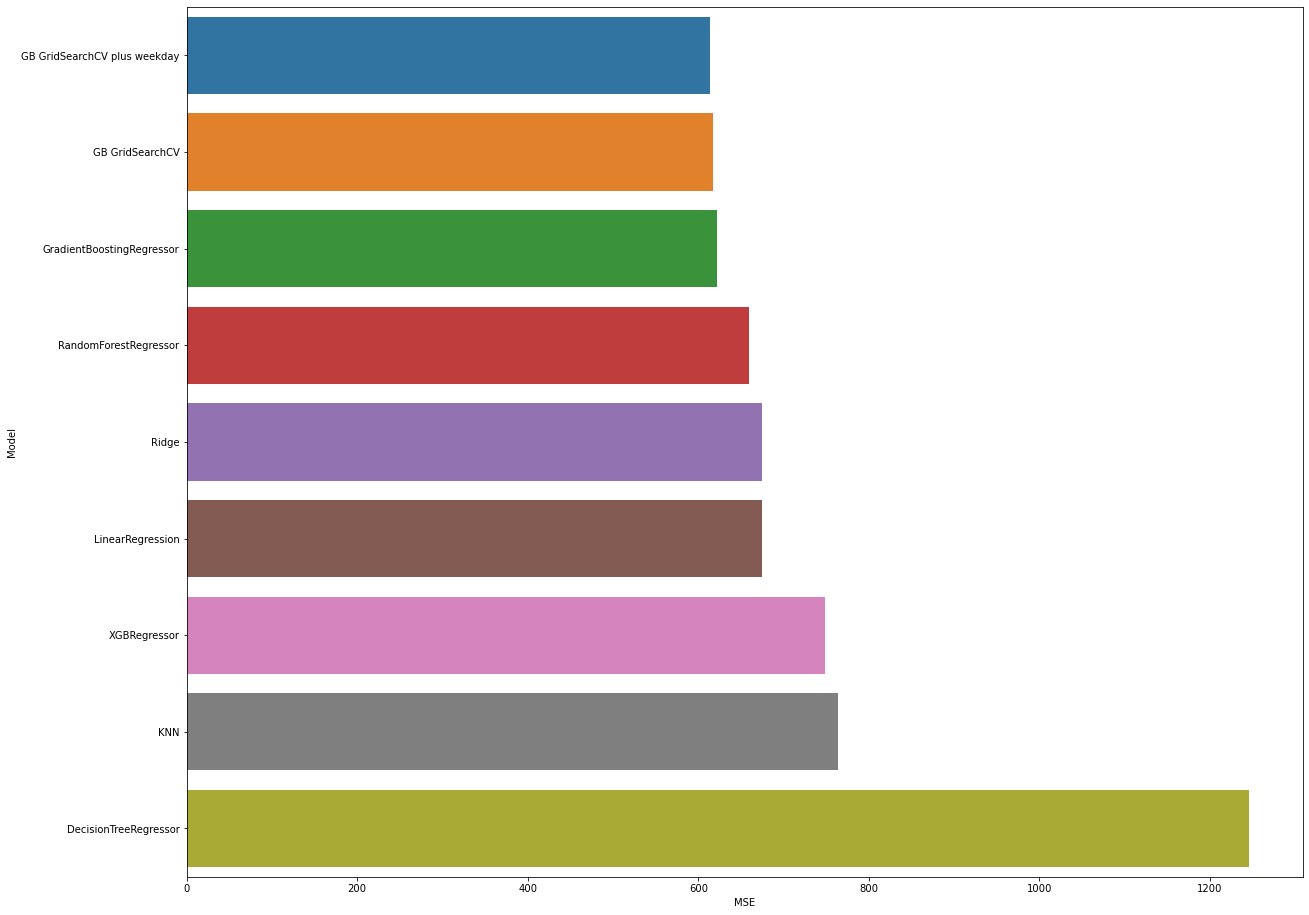

In [50]:
df_models.sort_values(by='MSE', ascending=True,inplace=True)
plt.figure(figsize=(20,16))
    #Plot Searborn bar chart
sns.barplot(x=df_models['MSE'], y=df_models['Model'])
plt.show()

To plot feature importance I need *normal* model, not trained using cross validation.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, 
                                                    test_size=0.2, 
                                                    random_state=42)
gb = GradientBoostingRegressor(learning_rate = 0.08, max_depth=3, min_samples_leaf= 2, min_samples_split=5, n_estimators=100)
gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.08, min_samples_leaf=2,
                          min_samples_split=5)

In [191]:
# Source: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,16))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    print(fi_df[['feature_names', 'feature_importance']])

   feature_names  feature_importance
0    Temperature            0.424900
4           Wind            0.206954
2       Humidity            0.199180
1  Precipitation            0.143613
3       Pressure            0.014252
5        Weekday            0.011101


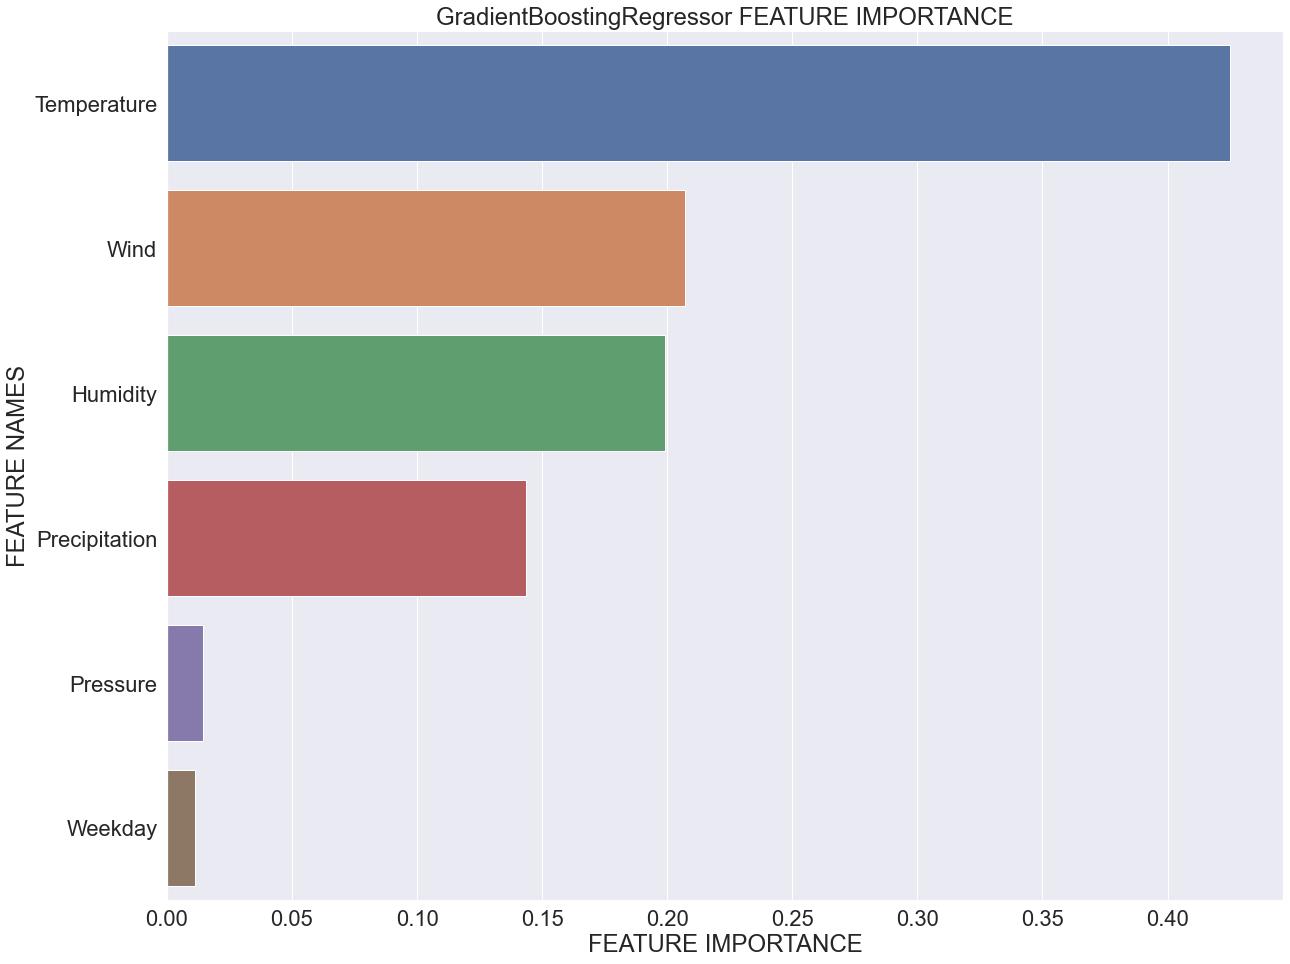

In [192]:
plot_feature_importance(gb.feature_importances_,X_2.columns,'GradientBoostingRegressor ')

# Testing model on real time data

I test my model performance on real time data.  
  
  
Weather data: IMGW API 'https://danepubliczne.imgw.pl/api/data/synop'  
Air polution data: web scraping using URL: 'https://aqicn.org/city/poland/mazowieckie/warszawa/marszalkowska/pl/'  
  
  
Libraries:
- requests
- json
- BeautifulSoup

In [52]:
import requests
import json
import datetime
from bs4 import BeautifulSoup

In [53]:
# weather data
URL_weather = 'https://danepubliczne.imgw.pl/api/data/synop'
response = requests.get(URL_weather)

In [54]:
response.text

'[{"id_stacji":"12295","stacja":"Bia\\u0142ystok","data_pomiaru":"2021-07-14","godzina_pomiaru":"17","temperatura":"27.2","predkosc_wiatru":"0","kierunek_wiatru":"0","wilgotnosc_wzgledna":"80.6","suma_opadu":"33.8","cisnienie":"1011.4"},{"id_stacji":"12600","stacja":"Bielsko Bia\\u0142a","data_pomiaru":"2021-07-14","godzina_pomiaru":"17","temperatura":"23.8","predkosc_wiatru":"2","kierunek_wiatru":"130","wilgotnosc_wzgledna":"73.4","suma_opadu":"0","cisnienie":"1009.9"},{"id_stacji":"12235","stacja":"Chojnice","data_pomiaru":"2021-07-14","godzina_pomiaru":"17","temperatura":"27.9","predkosc_wiatru":"3","kierunek_wiatru":"230","wilgotnosc_wzgledna":"56.0","suma_opadu":"0","cisnienie":"1010.2"},{"id_stacji":"12550","stacja":"Cz\\u0119stochowa","data_pomiaru":"2021-07-14","godzina_pomiaru":"17","temperatura":"24","predkosc_wiatru":"1","kierunek_wiatru":"150","wilgotnosc_wzgledna":"77.3","suma_opadu":"0","cisnienie":"1009.5"},{"id_stacji":"12160","stacja":"Elbl\\u0105g","data_pomiaru":"202

In [55]:
workday_val = datetime.datetime.today().weekday()

In [56]:
X_val = [[X_2.columns]]

In [57]:
for row in json.loads(response.text):
    if row['stacja'] == 'Warszawa':
        X_val.append([
            float(row['temperatura']),
            float(row['suma_opadu']),
            float(row['wilgotnosc_wzgledna']),
            float(row['cisnienie']),
            float(row['predkosc_wiatru']),
            workday_val])
        print(row)

{'id_stacji': '12375', 'stacja': 'Warszawa', 'data_pomiaru': '2021-07-14', 'godzina_pomiaru': '17', 'temperatura': '31.1', 'predkosc_wiatru': '2', 'kierunek_wiatru': '110', 'wilgotnosc_wzgledna': '57.7', 'suma_opadu': '0.9', 'cisnienie': '1009.9'}


In [58]:
X_val

[[Index(['Temperature', 'Precipitation', 'Humidity', 'Pressure', 'Wind',
         'Weekday'],
        dtype='object')],
 [31.1, 0.9, 57.7, 1009.9, 2.0, 2]]

I created 

In [59]:
# scraping current PM 2.5

URL_air = 'https://aqicn.org/city/poland/mazowieckie/warszawa/marszalkowska/pl/'
response_air = requests.get(URL_air)
soup = BeautifulSoup(response_air.content, 'html.parser')
y_val = float(soup.find('div', class_='aqivalue').get_text())

In [60]:
y_val = np.array(y_val).reshape(1, -1)

In [61]:
X_val = X_val[1]

In [62]:
X_val =np.array(X_val).reshape(1,-1)

In [63]:
y_preds_ = gb.predict(X_val)

In [64]:
mse_val = mean_squared_error(y_val, y_preds_)
mae_val = mean_absolute_error(y_val, y_preds_)

In [65]:
mse_val

55.94405414906052

In [66]:
mae_val

7.479575800074528